$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Neural Network vs Linear Regression analysis on the Dow Jones Industrial Average 

Anshuman Banerjee - CS480A3 - Machine Learning

## Overview

In this project we will perform regression analysis on the Dow Jones Industrial Average using Neural Networks and Linear Regression. The code for the neural network be used by the nn7 code base provided in the course. We have also borrowed some of the functions from CS480A3 Assignment 3 for computing the linear regression on the data.

Initially we had wanted to experiment with a variety of different stocks, however this created a massive complexity in the dataset. This includes some of the following, different stocks had diffent levels of volume, prices, and other attributes. We could not simply merge them into one data set for a common analysis, the effort involved in normalizing this data would be substancial.

Instead we decided to go with the Dow Jones Induatial Average (DJIA). This is an index composed of tracking stocks of 30 different companies spanning multiple industries [4] . Stocks get added and removed from the index, and typically  represent stocks which are leaders in their respective industries. Furthermore, the DJIA will also factor in the any kind of paymments (i.e. dividends) directly on the index which simplifies a complex element in keeping track of the stock values.

In this paper we will perform linear regression with four years of data from the DJIA, then we will perform a variety of different architectures for a neural network on the data. We will then use the K-Means cross validation method to analyze and interpret our results.

## Technical Requirements

In order to run this notebook the following python packages are required:

1) NN7, found at,   http://www.cs.colostate.edu/~anderson/cs480/notebooks/nn7.tar, contents must be extracted to the same directory as this notebook

2) Numpy, which can be found at, http://www.numpy.org/

3) Python 3.5 interpreter

4) yahoo_finance which can be found at, https://pypi.python.org/pypi/yahoo-finance

4) Matplotlib 

## Previous Work

There are several papers which have done analysis on the stock market using neural networks. [1]This paper has attempted to to predict stock fluctuations using neural networks using features from twitter. Yudong et al. attempt to predict the S&P 500 using the BCO approach and neural networks[2].

O'Conner et. al claims that they have built a neural network which gave a return of 23.5 % per annum, beating the DJIA [3]. Their neural network attempts to predict the current day's closing value. They also explore a variation in their features for their analysis, trying to find the best features for a certain type of market prediction.

## Data Features

We will use historical data from the stock market obtained via the yahoo finance API. Our data will consist of at  the following features for the DJIA for a specific day:

**Open**: The opening price for a stock on a given day

**Close**: the closing price for a stock on a given day

**Low**: The lowest value a stock was traded at on a given day

**High**: The highest value a stock was traded at on a given day

**Volume**: The number of shares that were traded on a given day

Here are two sample records, they represent two days worh of data directly from the source, our target attribute is the opening value of the DJIA for the next day given the current day's data:

{'Close': '520.390015', 'Open': '510.839996', 'Low': '509.589996', , 'Volume': '2317800', 'High': '521.849976', 'Date': '2015-01-21'}

{'Close': '530.390015', **'Open': '550.839996'**, 'Low': '519.589996', , 'Volume': '2314700', 'High': '531.849976', 'Date': '2015-01-22'}

Our data set also contains a date attribute, since this is non numeric value we cannot use it direclty as a feature, instead we will add four new features to our data set name:

**Q1**: Value of 1 or 0 indicating if the record belongs to the 1st quarter of the year (Janaury-March)

**Q2**: Value of 1 or 0 indicating if the record belongs to the 2nd quarter of the year (April-June)

**Q3**: Value of 1 or 0 indicating if the record belongs to the 3rd quarter of the year (July-September)

**Q4**: Value of 1 or 0 indicating if the record belongs to the 4th quarter of the year (October-December)

## Code base

In [32]:
import neuralnetworksbylayer as nn
import random
import math
import itertools
import numpy as np
import yahoo_finance as yf
import time
import matplotlib.pyplot as plt

%matplotlib inline

This function will return the quarter of the year a date belongs

In [33]:
def getQuarterDictionary(date):
    quarterDict = {1:0,2:0,3:0,4:0}
    timeStruct = time.strptime(date, '%Y-%m-%d');
    quarter = math.ceil(timeStruct.tm_mon/3.)
    quarterDict[quarter] = 1
    return quarterDict


TRAIN linear function borrowed from assignemnt 2

In [34]:
def train(X,T,lamb=0):
    means = X.mean(0)
    stds = X.std(0)
    n,d = X.shape
    Xs1 = np.hstack((np.ones((n,1)), (X - means)/stds))
    lambDiag = np.eye(d+1) * lamb
    lambDiag[0,0] = 0
    w = np.linalg.lstsq( np.dot(Xs1.T,Xs1) + lambDiag, np.dot(Xs1.T,T))[0]
    return {'w': w, 'means':means, 'stds':stds, 'lambda': lamb}


use linear function borrowed from assignment 2

In [35]:
def use(X,model):
    columnOfOnes = np.ones(( X.shape[0],1 ))
    Xs1 = np.hstack(( columnOfOnes, (X-model['means'])/model['stds']))
    return np.dot( Xs1, model['w'] )

rmse linear function borrowed from assignemnt 2

In [36]:
def rmse(A,B):
    return np.sqrt(np.mean( (A-B)**2 ))

Train linear invokes the train funtion above

In [37]:
def trainLinear(X,T,parameters):
    return train(X,T,parameters)


Evaluate linear invokes the use function of a linear model and return the RMSE on it

In [38]:
def evaluateLinear(model,X,T):
    predict = use(X, model)
    return rmse(predict, T)

Train NN creates a neural net object and trains on it

In [39]:
def trainNN(X,T,parameters):
    #print("Constructor:",parameters[0],"Train parameters",parameters[1])
    nnet = nn.NeuralNetwork([X.shape[1]] + [parameters[0]] + [T.shape[1]])
    return nnet.train(X, T, nIterations=parameters[1])


Uses the neural net model and then returns the error on it

In [40]:
def evaluateNN(model,X, T):
    Y = model.use(X)
    return np.sqrt(np.mean((Y-T)**2))

This is the function also borred from assignment 3 which will train and validate using the K-fold cross validation method

In [41]:
def trainValidateTestKFolds(trainf,evaluatef,X,T,parameterSets,nFolds,shuffle=False,verbose=False):
    # Randomly arrange row indices
    rowIndices = np.arange(X.shape[0])
    if shuffle:
        np.random.shuffle(rowIndices)
    # Calculate number of samples in each of the nFolds folds
    nSamples = X.shape[0]
    nEach = int(nSamples / nFolds)
    if nEach == 0:
        raise ValueError("partitionKFolds: Number of samples in each fold is 0.")
    # Calculate the starting and stopping row index for each fold.
    # Store in startsStops as list of (start,stop) pairs
    starts = np.arange(0,nEach*nFolds,nEach)
    stops = starts + nEach
    stops[-1] = nSamples
    startsStops = list(zip(starts,stops))
    # Repeat with testFold taking each single fold, one at a time
    results = []
    testSamples =[]
    validationSamples =[]

    # COMPLETE THIS FUNCTION BY IMPLEMENTING THE FOLLOWING STEPS.

    # For each test fold
    for testFold in range(nFolds):
        bestTrainError=-1
        bestValidateError=-1

        # For each set of parameter values, called parmSet
        for parmSet in parameterSets:

            paramTrainErrorSum=0
            paramValidateErrorSum=0
            # Find best set of parameter values

            # For each validate fold (except when same as test fold)
            for validateFold in range(nFolds):
                if testFold == validateFold:
                    continue

                # trainFolds are all remaining folds, after selecting test and validate folds
                trainFolds = np.setdiff1d(range(nFolds), [testFold,validateFold])
                # Construct Xtrain and Ttrain by collecting rows for all trainFolds
                rows = []
                for tf in trainFolds:
                    #print("Test Fold",testFold,"Parmater", parmSet, "validate Fold", validateFold, "train Fold", tf)
                    a,b = startsStops[tf]
                    rows += rowIndices[a:b].tolist()
                Xtrain = X[rows,:]
                Ttrain = T[rows,:]

                trainModel = trainf(Xtrain,Ttrain, parmSet)
                trainError = evaluatef(trainModel, Xtrain, Ttrain)
                paramTrainErrorSum = paramTrainErrorSum+trainError

                # Construct Xvalidate and Tvalidate
                a,b = startsStops[validateFold]
                rows = rowIndices[a:b]
                Xvalidate = X[rows,:]
                Tvalidate = T[rows,:]

                validateError = evaluatef(trainModel, Xvalidate, Tvalidate)
                paramValidateErrorSum = paramValidateErrorSum+validateError
                #print("trainError",trainError,"validateError", validateError, "paramValidateErrorSum", paramValidateErrorSum, "trainErrorSum", paramTrainErrorSum )


            # Calculate the mean of these errors.
            trainErrorMean = paramTrainErrorSum/(nFolds-1)
            validateErrorMean = paramValidateErrorSum/(nFolds-1)
            #print("trainErrorMean",trainErrorMean,"validateErrorMean", validateErrorMean)

            #print("Param:",parmSet, " test fold:" , testFold, " validate fold: ", validateFold)
            #print("trainErrorMean:",trainErrorMean, " validateErrorMean:" , validateErrorMean)
            # If this error is less than the previously best error for parmSet,update best parameter values and best error
            if(bestValidateError==-1 or validateErrorMean<bestValidateError):
                #print("Best error","")
                bestTrainError=trainErrorMean
                bestValidateError=validateErrorMean
                bestParam=parmSet
        # Make a new set of training data by concatenating the training and validation data from previous step.
        # Construct Xvalidate and Tvalidate
        testTrainFolds = np.setdiff1d(range(nFolds), [testFold])
        # Construct Xtrain and Ttrain by collecting rows for all trainFolds
        rows = []
        for tf in testTrainFolds:
            a,b = startsStops[tf]
            rows += rowIndices[a:b].tolist()
        testXTrain = X[rows,:]
        testTTrain = T[rows,:]

        #get test data
        a,b = startsStops[testFold]
        rows = rowIndices[a:b]
        testXEval = X[rows,:]
        testTEval = T[rows,:]

        # Retrain, using trainf again, to fit a new model to this new training data.
        XVTrain = trainf(testXTrain, testTTrain, bestParam)

        # Calculate error of this new model on the test data, and also on the new training data.
        XVError = evaluatef(XVTrain, testXEval, testTEval)

        # Construct a list of the best parameter values with this training error,the mean of the above valdiation errors, and the testing error
        testFoldList=[bestParam,bestTrainError,bestValidateError,XVError]

        # Print this list if verbose == True
        if verbose:
            print(testFoldList)

        # Append this list to a result list
        results.append(testFoldList)

    return results

Run the K-Fold cross validation method using Linear regression and will output the results, borrowed from assignment 3

In [42]:
def runKFoldLinear(X,T,params) :
    result = trainValidateTestKFolds(trainLinear,evaluateLinear,X,T,params,nFolds=5,shuffle=False)
    print('Linear Model\nlambda, train, validate, test RMSE')
    for x in result:
        print('{:.2f}    {:.3f}   {:.3f}   {:.3f}'.format(*x))


Run the K-Fold cross validation method using a neural net and will output the results, borrowed from assignment 3

In [43]:
def runKFoldNeuralNet(X,T, params):

    for i in range(5):
        result = trainValidateTestKFolds(trainNN, evaluateNN, X, T, params, nFolds=5, shuffle=False)
        result = np.array(result)

        # Sort by testing error: http://stackoverflow.com/a/2828121
        result= result[result[:, 3].argsort()]

        print()
        print('{:<30s} {:>12s} {:>15s} {:>12s}'.format("(Hidden Units, Iters.)", "Train RMSE", "Validate RMSE", "Test RMSE"))
        print("========================================================================")
        for x in result:
            print('{:<30s} {:12.3f} {:15.3f} {:12.3f}'.format(str(x[0]), x[1], x[2], x[3]))


This method is used to generate the stock data using the yahoo finance API, its input is the stock symbol, the start date of the historal data, the end date of the historical data

In [44]:
def makeStockData(stockSymbol, startDate, endDate):
    stock = yf.Share(stockSymbol)
    googleHistorical = stock.get_historical(startDate,endDate)
    lastItemIndex = len(googleHistorical) - 1
    XValues = []
    TValues = []
    for index, tradeDay in enumerate(googleHistorical):
        if index < lastItemIndex:
            quarterDict = getQuarterDictionary(tradeDay.get("Date"))
            XItem = [tradeDay.get("Close"), quarterDict[1], quarterDict[2],quarterDict[3],quarterDict[4], tradeDay.get("High"), tradeDay.get("Open"), tradeDay.get("Volume"), tradeDay.get("Low")]
            TItem = [googleHistorical[index + 1].get("Open")]
            XValues.append(XItem)
            TValues.append(TItem)
    XNames = ["Close" , "Q1","Q2","Q3","Q4", "High", "Open", "Volume", "Low"]
    TNames = ["NextDayOpen"]
    XArray = np.array(XValues).astype(np.float)
    TArray = np.array(TValues).astype(np.float)
    return XNames, TNames, XArray, TArray


## Data Fetching and Plotting

In [45]:
XNames, TNames, XArray, TArray = makeStockData("^DJI","2011-01-01","2015-12-31")

print(XArray.shape)

print(TArray.shape)



(1257, 9)
(1257, 1)


We see above that the XArray and the Target Array array have the same number of rows which allows us to plot and perform regression analysis on the data

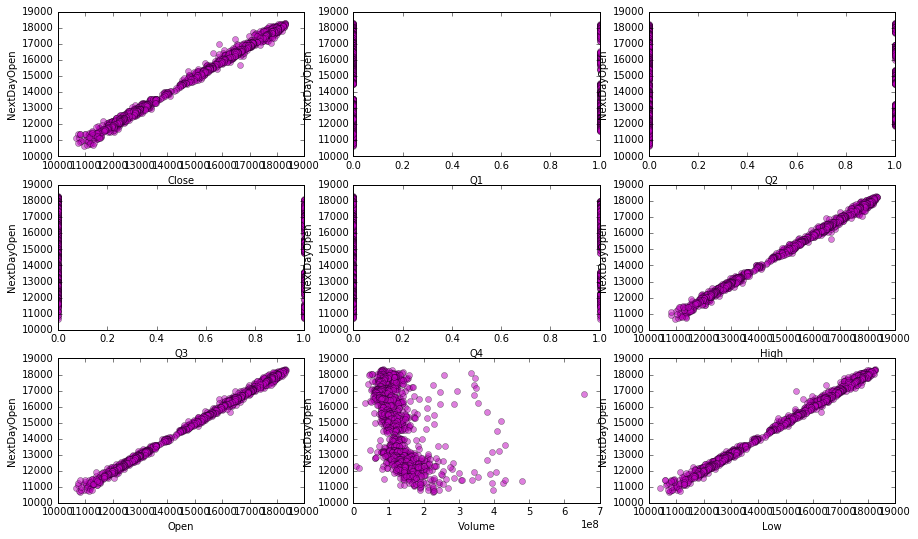

In [46]:
plt.figure(figsize=(15, 15))

for col in range(XArray.shape[1]):
    plt.subplot(5, 3, col+1)
    plt.plot(XArray[:, col], TArray, 'om', alpha=0.5)
    plt.ylabel(TNames[0])
    plt.xlabel(XNames[col])


### High, low, and close values

If we review the plots above we can see that the High, low, open, and close have a linear relationship with the next day open price. This is expected since the market typicailly does not fluctucate dramatically in one day. We do see some outliers which are outside of the linear regression. 

### Quarter values

In the quarterly charts, the values for 0 in the x-axis represent the next day open outside of the quarter and the values in the 1 in the x-axis represent the data which has values in the quarter. In our dataset the Q1 data has the least amount of variance where as Q2, Q3, and Q4 have a higher amount of variance. This indicates there is less volitity in Q1 then the other quarters.

### Volume Information

The volume varies around 100M +/- 50M a day. This may be due to the fact that we have used an index of the DJIA instead of an individual stock. Typically volumes would fluctuate more for an individual stock but this is masked by the we have an average of 30 stocks on the DJIA, which will normalize the number.

## Regression Analysis

### Linear Regression

In [47]:
linearParams = range(0,5,100)
runKFoldLinear(XArray, TArray, linearParams)


Linear Model
lambda, train, validate, test RMSE
0.00    112.333   112.498   156.147
0.00    125.133   124.230   110.278
0.00    128.747   128.620   91.987
0.00    127.692   127.574   98.206
0.00    115.041   114.071   148.646


Our best results came from having a lambda value of 0 on the results indicating that the linear model was  best  without any penalty on our dataaset. Our traning and vadalition errors were quite similar however testing errors fluctuated 15-40 percentage from our training and validation errors. Our best results allows us to predict the next day opening price within ~ 98 points. At the end of our traning data (on december 31st 2015) the DJIA value was at 17245 so a 98 point margin would be a 0.5624% error rate.

### Neural Network Regression

In [48]:
neuralNetParams = [(6,6,8,100), (2, 25), (2, 50), (2, 75), (2, 100), (5, 25), (5, 50), (5, 75), (5, 100), (10, 25), (10, 50), (10, 75), (10, 100), (12, 25), (12, 50), (12, 75), (12, 100)]

runKFoldNeuralNet(XArray, TArray, neuralNetParams)


(Hidden Units, Iters.)           Train RMSE   Validate RMSE    Test RMSE
(10, 75)                           1030.600        1487.623      349.272
(12, 75)                           1023.238        1447.538      496.860
(5, 75)                            1410.584        1520.339      678.796
(12, 100)                           787.772        1035.315      813.797
(5, 75)                            1021.045        1049.909     3374.272

(Hidden Units, Iters.)           Train RMSE   Validate RMSE    Test RMSE
(12, 100)                          1013.625        1118.132     1018.779
(10, 100)                           772.727        1013.850     1207.743
(5, 100)                            701.255        1107.335     1536.521
(10, 75)                            975.335         820.729     1599.437
(10, 100)                           858.741        1536.506     1751.081

(Hidden Units, Iters.)           Train RMSE   Validate RMSE    Test RMSE
(10, 75)                            914.406     

Our best results in the neural net came from a neural net architecture of 10 hidden units with 75 iterations. On all five trials it seems the majoriy of our best results came from a neural net with 10 hidden units with a variation of 75 to a 100 iterations.There was a strong fluctuation between the training data, and the valdation data, sometimes more then 100%. There was a wider variation between the training and testing data where there was a difference of more then 500%.

## Conclusion

Our results from the neural network was not very successful. The linear regression had much better results the the neural net. It was also interesting to see that the linear regression had best results with a lambda value of 0 which meant no punishment to the linear model. This indicates that our data is linearly correlated.  We did not do further analysis to research the hidden layers due their performance when compared to the linear model. 

## Future Work

If we want to continue with linear regression, it will be useful to get more features outside of the yahoo finance API, such as quarterly profit, revenue, earnings per share. In addition we can standardize the data further by calculating the change in terms of percentage between the current day and previous days values. This way we can integrate multiple stocks into the dataset without having a wide variance of values between them. Finally, once we have a model which consistently validates and tests our data, we can use it to develop a trading strategy.

## References

[1] Bollen, Johan, Huina Mao, and Xiao-Jun Zeng. Twitter mood predicts the stock market. Journal of Computational Science, 2011.

[2] Yudong, Z., & Lenan, W. (2009). Stock market prediction of S&P 500 via combination of improved BCO approach and BP neural network. Expert Systems with Applications, 36(5), 8849–8854

[3] N. O’Connor, M.G. Madden, A neural network approach to predicting stock exchange movements using external factors, Knowl. Based Syst. 19 (2006) 371–378

[4] https://en.wikipedia.org/wiki/Dow_Jones_Industrial_Average

[5] Boyacioglu, M., Avci, D.: An adaptive network-based fuzzy inferencesystems (ANFIS) for prediction of stock market return: the caseof Istanbul stock exchange. In: Expert Systems with Applications, vol. 37, pp. 7902–7912 (2010)

[6] https://archive.ics.uci.edu/ml/datasets/dow+jones+index